In [3]:
import pandas
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import time
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
#from keras.utils import to_categorical
import feather
import random
from datetime import *

import warnings
warnings.filterwarnings("ignore")


In [5]:
FILENAME = "Datasets/final_datasets/merged_data"

In [92]:
data = feather.read_dataframe(f"{FILENAME}.feather")

In [93]:
# Remove those one-hot encoded columns in the dataset created by Abhi

def in_name(c, one_hots):
    for col_name in one_hots:
        if c.startswith(f"{col_name}_"):
            return True
    return False

one_hots = ['Wind_Direction', 'Timezone','State', 'Weather_Condition']
remove = [col for col in data.columns if in_name(col, one_hots)]
data = data.drop(remove, axis=1)

In [94]:
# Remove missing values
data = data.dropna().reset_index(drop=True)
print(len(df))

2922400


In [95]:
# Get the grouped severity

data['Severity'] = data['Severity'].astype(int)
data['Grouped_Severity'] = np.where(data['Severity']<=2, 0, 1)
data = data.drop('Severity', axis=1)

# Clean categorical features

### Clean wind direction

* "CALM" = ["Calm", "CALM"]
* "W" = ["W", "West", "WSW", "WNW"] 
* "S" = ["S", "South", "SSW", "SSE"] 
* "N" = ["N", "North", "NNW", "NNE"] 
* "E" = ["E", "East", "ESE", "ENE"]
* "VAR" = ["VAR", "Variable"]

In [96]:
df.loc[df['Wind_Direction']=='Calm','Wind_Direction'] = 'CALM'
df.loc[(df['Wind_Direction']=='West')|(df['Wind_Direction']=='WSW')|(df['Wind_Direction']=='WNW'),'Wind_Direction'] = 'W'
df.loc[(df['Wind_Direction']=='South')|(df['Wind_Direction']=='SSW')|(df['Wind_Direction']=='SSE'),'Wind_Direction'] = 'S'
df.loc[(df['Wind_Direction']=='North')|(df['Wind_Direction']=='NNW')|(df['Wind_Direction']=='NNE'),'Wind_Direction'] = 'N'
df.loc[(df['Wind_Direction']=='East')|(df['Wind_Direction']=='ESE')|(df['Wind_Direction']=='ENE'),'Wind_Direction'] = 'E'
df.loc[df['Wind_Direction']=='Variable','Wind_Direction'] = 'VAR'
print("Wind Direction after simplification: ", df['Wind_Direction'].unique())

Wind Direction after simplification:  ['SW' 'S' 'W' 'NW' 'N' 'VAR' 'SE' 'E' 'NE' 'CALM']


### Clean weather condition

In [8]:
Counter(df['Weather_Condition'])

Counter({'Overcast': 314137,
         'Mostly Cloudy': 432506,
         'Light Rain': 150052,
         'Light Snow': 46407,
         'Haze': 29015,
         'Scattered Clouds': 170312,
         'Partly Cloudy': 306197,
         'Clear': 597336,
         'Snow': 5176,
         'Light Freezing Drizzle': 716,
         'Fog': 24155,
         'Shallow Fog': 710,
         'Rain': 32900,
         'Heavy Rain': 13063,
         'Light Freezing Rain': 1800,
         'Cloudy': 205447,
         'Smoke': 2831,
         'Patches of Fog': 1487,
         'Mist': 1395,
         'Light Freezing Fog': 478,
         'Light Thunderstorms and Rain': 3807,
         'Light Drizzle': 9415,
         'Thunderstorms and Rain': 1620,
         'Fair': 523539,
         'Blowing Dust / Windy': 115,
         'Widespread Dust': 147,
         'Fair / Windy': 7741,
         'Drizzle': 1197,
         'Light Rain / Windy': 1991,
         'Heavy Drizzle': 162,
         'Showers in the Vicinity': 238,
         'Light Rain wi

https://www.timeanddate.com/weather/glossary.html <br>

**Create features according the different weather conditions** <br>
Scattered clouds, partly cloudy = PARTLY CLOUDY <br>
Overcast, Mostly cloudly, Cloudy = CLOUDY <br>
Fair, Clear = CLEAR <br>
Snow (light snow, heavy snow), and wintry mix  = SNOW <br>
drizzle, light rain/drizzle, light freezing rain/drizzle = LIGHT RAIN <br>
Heavy Rain, heavy thunderstorms, heavy t-storm = HEAVY RAIN <br>
Haze, fog, mist, smoke = fog     *(see https://www.worldatlas.com/articles/what-are-the-differences-between-mist-haze-and-fog.html)*<br>
Rain, light thunderstorms, thunderstorms, t-storm, thunder = RAIN <br>

In [56]:
conditions = ['Clear', 'Partly Cloudy', 'Cloudy', 'Light Snow', 'Heavy Snow', 'Snow',
              'Heavy Rain', 'Heavy Thunderstorm', 'Thunderstorm', 'Light Rain',  'Rain', 
              'Fog'] 

def get_condition(string, conditions):
    strings = [['clear', 'fair'],
               ['partly cloudy', 'scattered clouds'],
               ['overcast', 'mostly cloudy', 'cloudy'],
               ['light snow', 'light ice', 'wintry mix'],
               ['heavy snow', 'blowing snow'],
               ['snow'],
               ['heavy rain', 'heavy drizzle'],
               ['heavy thunderstorms', 'heavy t-storm'],
               ['thunder', 't-storm'],
               ['drizzle', 'light rain', 'light freezing rain'],
               ['rain', 'thunderstorms', 't-storm', 'thunder', 'showers'],
               ['fog', 'haze', 'mist', 'smoke']]

    for j, k in enumerate(strings):
        for val in k:
            if val in string.lower():
                return conditions[j]
    return 'Others'

In [97]:
res = []
for i in data['Weather_Condition'].values:
    res.append(get_condition(i, conditions))

data['Condition'] = res

for i in conditions+['Others']:
    print(i, ":")
    print(set(data[data['Condition']==i]['Weather_Condition']))
    print(sum(data['Condition']==i))
    print("\n")
    
data = data[data['Condition']!='Others']

Clear :
{'Fair', 'Clear', 'Fair / Windy'}
1128616


Partly Cloudy :
{'Partly Cloudy', 'Scattered Clouds', 'Partly Cloudy / Windy'}
479226


Cloudy :
{'Mostly Cloudy', 'Cloudy', 'Mostly Cloudy / Windy', 'Cloudy / Windy', 'Overcast'}
960533


Light Snow :
{'Light Snow / Windy', 'Light Ice Pellets', 'Wintry Mix', 'Light Snow'}
49183


Heavy Snow :
{'Heavy Snow', 'Blowing Snow'}
1657


Snow :
{'Snow / Windy', 'Snow'}
5288


Heavy Rain :
{'Heavy Rain / Windy', 'Heavy Rain', 'Heavy Drizzle'}
13516


Heavy Thunderstorm :
{'Heavy Thunderstorms and Rain', 'Heavy T-Storm / Windy', 'Heavy T-Storm'}
4088


Thunderstorm :
{'Thunder in the Vicinity', 'Light Rain with Thunder', 'Thunderstorms and Rain', 'Light Thunderstorms and Rain', 'T-Storm', 'Thunderstorm', 'Thunder / Windy', 'Thunder', 'T-Storm / Windy'}
20548


Light Rain :
{'Light Drizzle', 'Drizzle', 'Light Freezing Rain', 'Drizzle and Fog', 'Light Freezing Drizzle', 'Light Rain / Windy', 'Light Rain'}
165300


Rain :
{'Rain / Windy', 'Shower

In [98]:
# Save this dataframe
data = data.reset_index(drop = True)
data.to_feather("{}_v1.feather".format(FILENAME))

# Correlation for numeric attributes

In [6]:
data = feather.read_dataframe("{}_v1.feather".format(FILENAME))

### NOTE: At this point we already did some basic outlier removal in previous files

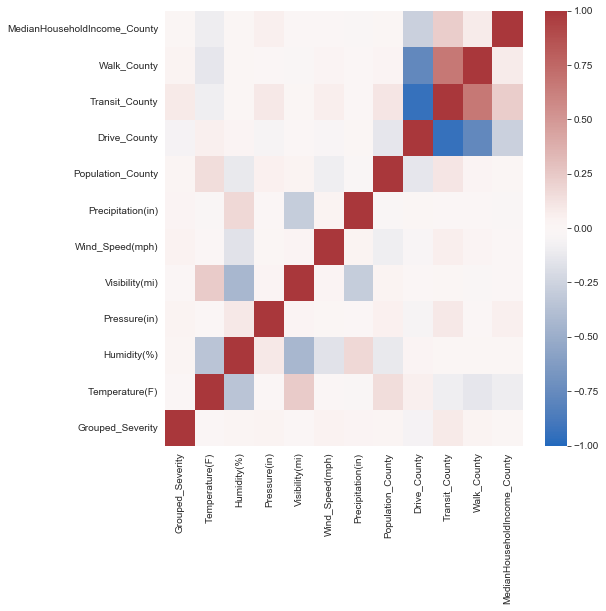

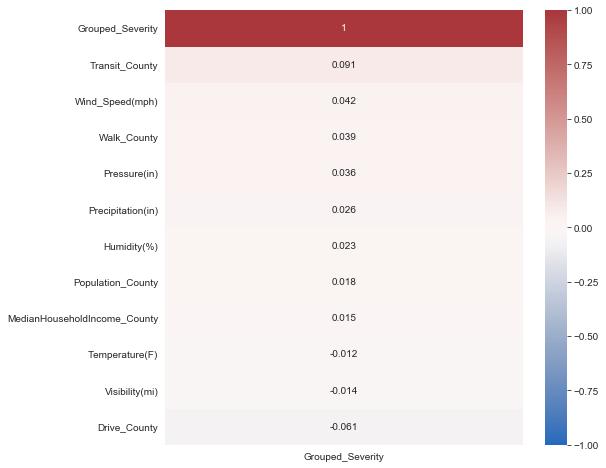

In [100]:
cols = ['Grouped_Severity', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
        'Wind_Speed(mph)', 'Precipitation(in)',
       'Population_County', 'Drive_County', 'Transit_County', 'Walk_County', 'MedianHouseholdIncome_County']

plt.figure(figsize=(8,8))
ax = sns.heatmap(data[cols].corr(),
 vmax=1, vmin=-1, cmap=sns.color_palette("vlag", as_cmap=True));
ax.invert_yaxis()
plt.show()


plt.figure(figsize=(8,8))
ax = sns.heatmap(data[cols].corr()[['Grouped_Severity']].sort_values('Grouped_Severity'),
 vmax=1, vmin=-1, cmap=sns.color_palette("vlag", as_cmap=True), annot=True);
ax.invert_yaxis()
plt.show()

# Feature engineering

### Create hour, weekend, and month attributes

In [8]:
data['Start_Time'] = pd.to_datetime(data['Start_Time'])

data['Hour'] = data['Start_Time'].dt.hour
data['Weekday'] = data['Start_Time'].dt.weekday
data['Month'] = data['Start_Time'].dt.month

# Chi Square Categorical Attributes

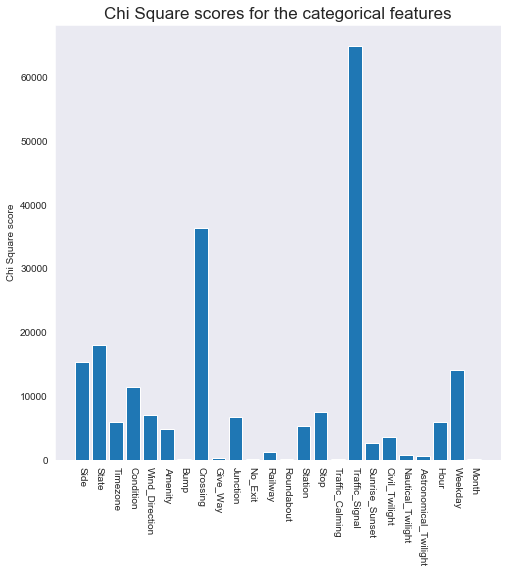

In [9]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# prepare input data
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

col_names = ['Side', 'State', 'Timezone', 'Condition', 'Wind_Direction',
             'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 
             'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 
             'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight',
             'Hour', 'Weekday', 'Month'
            ]
X_train, X_test, y_train, y_test = train_test_split(data[col_names],
                                                    data['Grouped_Severity'], test_size=0.33, random_state=30034)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
# what are scores for the features

# for i in range(len(fs.scores_)):
#     print(f"{col_names[i]}: {fs.scores_[i]}")

sns.set_style("dark")
plt.figure(figsize=(8,8))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.xticks(range(len(col_names)), col_names, rotation=270)
plt.ylabel('Chi Square score')
plt.title("Chi Square scores for the categorical features", fontsize=17)
plt.show()

# Save the dataset

In [11]:
one_hots = ['Timezone', 'Wind_Direction','State', 'Condition', 'Hour', 'Weekday']
oh = pd.DataFrame()
for c in one_hots:
    dummies = pd.get_dummies(data[c], prefix=c)
    oh = pd.concat([oh, dummies], axis=1)

data = pd.concat([data, oh], axis=1)

In [13]:
# Remove those logical/categorical attributes that seem irrelevant + any irrelevant attributes

drop = ['Unnamed: 0', 'ID', 'Start_Lat', 'Start_Lng', 'Start_Time', 'End_Time', 'Weather_Timestamp', 'Description', 
        'Distance(mi)', 
        'County', 'City', 'Airport_Code', 'State', 
        'Wind_Direction', 'Timezone', 'Condition', 'Weather_Condition',
        'Street', 'Bump', 'No_Exit', 'Railway', 'Roundabout', 'Give_Way', 'Traffic_Calming',
        'Nautical_Twilight', 'Astronomical_Twilight',
        'Hour', 'Weekday', 'Month']

data = data.drop(drop, axis=1).reset_index(drop=True)

In [14]:
# Save this dataframe
data = data.reset_index(drop = True)
data.to_feather("{}_v1.feather".format(FILENAME))

#### With numeric attributes

In [16]:
# Filter the data
#BUM NOEXIT ROUNABOUT GIVEWAY removed due to badly distributed data
df = feather.read_dataframe("{}_v1.feather".format(FILENAME))
df.to_feather("{}_numeric_v2.feather".format(FILENAME))
del(df)

#### without numeric attributes

In [18]:
# Filter the data
#BUM NOEXIT ROUNABOUT GIVEWAY removed due to badly distributed data
df = feather.read_dataframe("{}_v1.feather".format(FILENAME))
num_cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Population_County', 'Drive_County', 'Transit_County', 'Walk_County', 'MedianHouseholdIncome_County']

df = df.drop(num_cols, axis=1).reset_index(drop=True)

# Convert to feather file format
df.to_feather("{}_v2.feather".format(FILENAME))

# Clear memory
del(df)

# Model

In [27]:
# Model Function
def Neural_Network(X,labels,neuron_size,epoch_size,k_folds):
    scaler=MinMaxScaler(feature_range=(0,1))
    X = scaler.fit_transform(X)
    
    skf = StratifiedKFold(n_splits=k_folds, random_state=30034, shuffle=True)

    fold_no = 1
    accs = []  # store each accuracy


    for train_index, test_index in skf.split(X, labels):

        # One hot encode labels
        print("FOLD NUMBER = ", str(fold_no))


        X_train = X[train_index]
        X_test = X[test_index]

        y_train = labels[train_index]
        y_test = labels[test_index]

        EPOCHS = epoch_size
        BATCH_SIZE = 128


        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(neuron_size,input_dim=X_train.shape[1], activation='relu'))
        model.add(tf.keras.layers.Dense(int(2/3*neuron_size), activation=tf.nn.leaky_relu))
        model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))
        # Compile model
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
        
        y_preds = model.predict(X_test)
        p = []
        for i in y_preds:
            p.append(np.argmax(i))

        test_acc = accuracy_score(y_test, p)
        accs.append(test_acc)
        
        print("\nTest Accuracy:", test_acc)

        cm=confusion_matrix(y_test,p)
        cm = pd.DataFrame(cm, index = [i for i in "01"],
                          columns = [i for i in "01"])
        cm.index.name = 'Actual'
        cm.columns.name = 'Predicted'
        sns.heatmap(cm, annot=True, 
                    cmap='Blues', cbar=False)
        plt.show()

        print("============================================")
        fold_no+=1

    return accs

### Model evaluation with numeric

In [20]:
data.shape

(2921810, 139)

C:\Users\liyoa\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


FOLD NUMBER =  1
Instructions for updating:
Colocations handled automatically by placer.
Epoch 1/10
2337447/2337447 [==============================] - 45s 19us/sample - loss: 0.5099 - acc: 0.7340
Epoch 2/10
2337447/2337447 [==============================] - 41s 18us/sample - loss: 0.4979 - acc: 0.7428
Epoch 3/10
2337447/2337447 [==============================] - 41s 18us/sample - loss: 0.4925 - acc: 0.7467
Epoch 4/10
2337447/2337447 [==============================] - 41s 18us/sample - loss: 0.4889 - acc: 0.7493
Epoch 5/10
2337447/2337447 [==============================] - 42s 18us/sample - loss: 0.4866 - acc: 0.7511
Epoch 6/10
2337447/2337447 [==============================] - 42s 18us/sample - loss: 0.4846 - acc: 0.7526
Epoch 7/10
2337447/2337447 [==============================] - 43s 18us/sample - loss: 0.4830 - acc: 0.7538
Epoch 8/10
2337447/2337447 [==============================] - 42s 18us/sample - loss: 0.4818 - acc: 0.7545
Epoch 9/10
2337447/2337447 [===========================

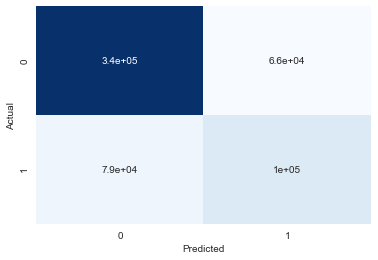

FOLD NUMBER =  2
Epoch 1/10
1054464/2337448 [============>.................] - ETA: 24s - loss: 0.5172 - acc: 0.7289

KeyboardInterrupt: 

In [23]:
data = feather.read_dataframe("{}_numeric_v2.feather".format(FILENAME))
y = data['Grouped_Severity']
X = data.drop(["Grouped_Severity"], axis=1)

accuracies = Neural_Network(X,y,90,10,5)
for i in range(1,4):
    print("Fold ",i," Accuracy: ",accuracies[i-1])
print("Average Accuracy: ",np.mean(accuracies))

### Model evaluation without numeric

In [28]:
data = feather.read_dataframe("{}_v2.feather".format(FILENAME))
y = data['Grouped_Severity']
X = data.drop(["Grouped_Severity"], axis=1)

accuracies = Neural_Network(X,y,90,10,3)
for i in range(1,4):
    print("Fold ",i," Accuracy: ",accuracies[i])
print("Average Accuracy: ",np.mean(accuracies))

FOLD NUMBER =  1
Epoch 1/10
1947873/1947873 [==============================] - 38s 20us/sample - loss: 0.5200 - acc: 0.7282
Epoch 2/10
1360000/1947873 [===================>..........] - ETA: 11s - loss: 0.5140 - acc: 0.7323

KeyboardInterrupt: 

### Finding best neuron size

@Terry pls run this on your pc 

In [ ]:
data = feather.read_dataframe("{}_numeric_v2.feather".format(FILENAME))

y = data['Grouped_Severity']
X = data.drop(["Grouped_Severity"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=30034)

max_neurons = X_train.shape[1]
neuron_size = range(max_neurons,4,-10)

accs = []

for i in neuron_size:
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(i,input_dim=X_train.shape[1], activation='relu'))
    model.add(tf.keras.layers.Dense(int(2/3*i), activation=tf.nn.leaky_relu))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=10, batch_size=128)
    (test_loss, test_acc) = model.evaluate(X_test, y_test)
    print('Accuracy:', test_acc)
    accs.append(test_acc)

#plotting line graph of accuracy vs neuron_size
sns.set_style("darkgrid")
plt.plot(neuron_size, accuracies, label="Accuracy")

    
best_neuron_size = neuron_size[np.argmax(accs)]
print("\nBEST NEURON SIZE =", best_neuron_size)

# Create balanced data

In [23]:
# Minimise the number of features to speed up the undersampling process or else pc goes boom boom

data = feather.read_dataframe("{}_numeric_v2.feather".format(FILENAME))

def in_name(c, one_hots):
    # Remove one hot encoded columns
    for col_name in one_hots:
        if c.startswith(f"{col_name}_"):
            return True
    return False

one_hots = ['State', 'Wind_Direction', 'Hour', 'Timezone']
oh_cols = [col for col in data.columns if in_name(col, one_hots)]
num_cols = ['Temperature(F)', 'Visibility(mi)', 'Population_County', 'MedianHouseholdIncome_County', 'Humidity(%)', 'Precipitation(in)']
log_cols = ['Amenity', 'Junction', 'Sunrise_Sunset', 'Civil_Twilight', 'Station']

data = data.drop(oh_cols+num_cols+log_cols, axis=1)

In [24]:
print([c for c in data.columns])

['Side', 'Pressure(in)', 'Wind_Speed(mph)', 'Crossing', 'Stop', 'Traffic_Signal', 'Drive_County', 'Transit_County', 'Walk_County', 'Grouped_Severity', 'Condition_Clear', 'Condition_Cloudy', 'Condition_Fog', 'Condition_Heavy Rain', 'Condition_Heavy Snow', 'Condition_Heavy Thunderstorm', 'Condition_Light Rain', 'Condition_Light Snow', 'Condition_Partly Cloudy', 'Condition_Rain', 'Condition_Snow', 'Condition_Thunderstorm', 'Weekday_0', 'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6']


In [ ]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss

data = feather.read_dataframe("{}_numeric_v2.feather".format(FILENAME))
data = data.sample(n=20000, random_state=30034)

y = data['Grouped_Severity']
X = data.drop(["Grouped_Severity",'Precipitation(in)','Visibility(mi)'], axis=1)

scaler=MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

print(Counter(y))

# rus = RandomUnderSampler(random_state=30034)
# X, y = rus.fit_resample(X, y)

undersample = NearMiss(version=2, n_neighbors=3)
X, y = undersample.fit_resample(X, y)

print(Counter(y))

Counter({0: 13840, 1: 6160})


In [ ]:
# The accuracy below is for 20,000 instances sampled from the dataset... i can't do higher or it goes boom

FOLD NUMBER =  1
Epoch 1/20
9856/9856 [==============================] - 0s 47us/sample - loss: 0.6302 - acc: 0.6310
Epoch 2/20
9856/9856 [==============================] - 0s 15us/sample - loss: 0.5676 - acc: 0.6902
Epoch 3/20
9856/9856 [==============================] - 0s 16us/sample - loss: 0.5477 - acc: 0.7054
Epoch 4/20
9856/9856 [==============================] - 0s 15us/sample - loss: 0.5327 - acc: 0.7157
Epoch 5/20
9856/9856 [==============================] - 0s 16us/sample - loss: 0.5203 - acc: 0.7262
Epoch 6/20
9856/9856 [==============================] - 0s 17us/sample - loss: 0.5065 - acc: 0.7374
Epoch 7/20
9856/9856 [==============================] - 0s 15us/sample - loss: 0.4941 - acc: 0.7457
Epoch 8/20
9856/9856 [==============================] - 0s 15us/sample - loss: 0.4793 - acc: 0.7542
Epoch 9/20
9856/9856 [==============================] - 0s 16us/sample - loss: 0.4643 - acc: 0.7639
Epoch 10/20
9856/9856 [==============================] - 0s 16us/sample - loss: 0.4

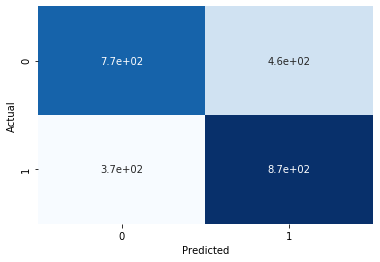

FOLD NUMBER =  2
Epoch 1/20
9856/9856 [==============================] - 0s 50us/sample - loss: 0.6312 - acc: 0.6210
Epoch 2/20
9856/9856 [==============================] - 0s 16us/sample - loss: 0.5661 - acc: 0.6951
Epoch 3/20
9856/9856 [==============================] - 0s 17us/sample - loss: 0.5485 - acc: 0.7062
Epoch 4/20
9856/9856 [==============================] - 0s 19us/sample - loss: 0.5312 - acc: 0.7233
Epoch 5/20
9856/9856 [==============================] - 0s 16us/sample - loss: 0.5161 - acc: 0.7313
Epoch 6/20
9856/9856 [==============================] - 0s 16us/sample - loss: 0.4999 - acc: 0.7432
Epoch 7/20
9856/9856 [==============================] - 0s 17us/sample - loss: 0.4841 - acc: 0.7571
Epoch 8/20
9856/9856 [==============================] - 0s 18us/sample - loss: 0.4675 - acc: 0.7699
Epoch 9/20
9856/9856 [==============================] - 0s 18us/sample - loss: 0.4556 - acc: 0.7766
Epoch 10/20
9856/9856 [==============================] - 0s 18us/sample - loss: 0.4

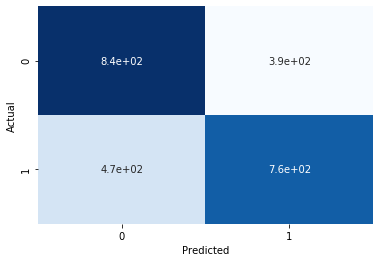

FOLD NUMBER =  3
Epoch 1/20
9856/9856 [==============================] - 1s 51us/sample - loss: 0.6356 - acc: 0.6306
Epoch 2/20
9856/9856 [==============================] - 0s 18us/sample - loss: 0.5709 - acc: 0.6894
Epoch 3/20
9856/9856 [==============================] - 0s 18us/sample - loss: 0.5513 - acc: 0.7004
Epoch 4/20
9856/9856 [==============================] - 0s 17us/sample - loss: 0.5356 - acc: 0.7147
Epoch 5/20
9856/9856 [==============================] - 0s 16us/sample - loss: 0.5227 - acc: 0.7222
Epoch 6/20
9856/9856 [==============================] - 0s 17us/sample - loss: 0.5107 - acc: 0.7362
Epoch 7/20
9856/9856 [==============================] - 0s 17us/sample - loss: 0.4959 - acc: 0.7457
Epoch 8/20
9856/9856 [==============================] - 0s 18us/sample - loss: 0.4822 - acc: 0.7562
Epoch 9/20
9856/9856 [==============================] - 0s 20us/sample - loss: 0.4691 - acc: 0.7652
Epoch 10/20
9856/9856 [==============================] - 0s 20us/sample - loss: 0.4

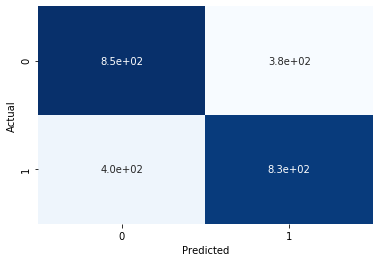

FOLD NUMBER =  4
Epoch 1/20
9856/9856 [==============================] - 1s 52us/sample - loss: 0.6272 - acc: 0.6367
Epoch 2/20
9856/9856 [==============================] - 0s 19us/sample - loss: 0.5686 - acc: 0.6872
Epoch 3/20
9856/9856 [==============================] - 0s 18us/sample - loss: 0.5520 - acc: 0.7011
Epoch 4/20
9856/9856 [==============================] - 0s 18us/sample - loss: 0.5336 - acc: 0.7154
Epoch 5/20
9856/9856 [==============================] - 0s 17us/sample - loss: 0.5199 - acc: 0.7293
Epoch 6/20
9856/9856 [==============================] - 0s 18us/sample - loss: 0.5074 - acc: 0.7376
Epoch 7/20
9856/9856 [==============================] - 0s 19us/sample - loss: 0.4938 - acc: 0.7455
Epoch 8/20
9856/9856 [==============================] - 0s 23us/sample - loss: 0.4814 - acc: 0.7583
Epoch 9/20
9856/9856 [==============================] - 0s 19us/sample - loss: 0.4660 - acc: 0.7678
Epoch 10/20
9856/9856 [==============================] - 0s 17us/sample - loss: 0.4

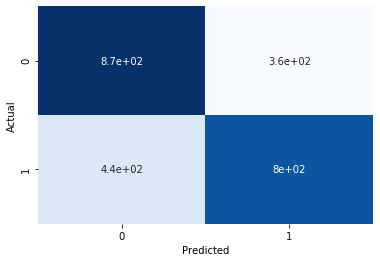

FOLD NUMBER =  5
Epoch 1/20
9856/9856 [==============================] - 1s 54us/sample - loss: 0.6264 - acc: 0.6332
Epoch 2/20
9856/9856 [==============================] - 0s 19us/sample - loss: 0.5698 - acc: 0.6902
Epoch 3/20
9856/9856 [==============================] - 0s 18us/sample - loss: 0.5519 - acc: 0.7040
Epoch 4/20
9856/9856 [==============================] - 0s 19us/sample - loss: 0.5396 - acc: 0.7120
Epoch 5/20
9856/9856 [==============================] - 0s 21us/sample - loss: 0.5268 - acc: 0.7230
Epoch 6/20
9856/9856 [==============================] - 0s 17us/sample - loss: 0.5145 - acc: 0.7328
Epoch 7/20
9856/9856 [==============================] - 0s 18us/sample - loss: 0.5042 - acc: 0.7407
Epoch 8/20
9856/9856 [==============================] - 0s 18us/sample - loss: 0.4865 - acc: 0.7513
Epoch 9/20
9856/9856 [==============================] - 0s 19us/sample - loss: 0.4718 - acc: 0.7657
Epoch 10/20
9856/9856 [==============================] - 0s 17us/sample - loss: 0.4

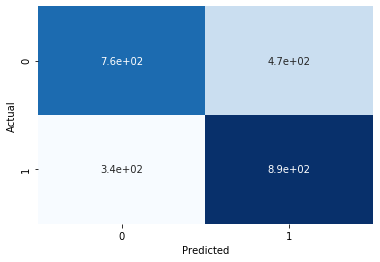

0.6684253


In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

skf = StratifiedKFold(n_splits=5, random_state=30034, shuffle=True)
fold_no = 1
accs = []  # store each accuracy

neuron_size = 90

for train_index, test_index in skf.split(X, y):

    # One hot encode labels
    print("FOLD NUMBER = ", str(fold_no))

    X_train = X[train_index]
    X_test = X[test_index]

    y_train = y[train_index]
    y_test = y[test_index]

    EPOCHS = 20
    BATCH_SIZE = 128

    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(neuron_size,input_dim=X_train.shape[1], activation='relu'))
    model.add(tf.keras.layers.Dense(int(2/3*neuron_size), activation=tf.nn.leaky_relu))
    model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
    
    y_preds = model.predict(X_test)
    p = []
    for i in y_preds:
        p.append(np.argmax(i))

    test_acc = accuracy_score(y_test, p)
    accs.append(test_acc)

    print("\nTest Accuracy:", test_acc)

    cm=confusion_matrix(y_test,p)
    cm = pd.DataFrame(cm, index = [i for i in "01"],
                      columns = [i for i in "01"])
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    sns.heatmap(cm, annot=True, 
                cmap='Blues', cbar=False)
    plt.show()

    print("============================================")
    fold_no+=1

print(np.mean(accs))

### Performing  outlier removal

In [ ]:
#function for removing outliers in numeric data
def outlier_removal(data,columns):
    for col in columns:
        Q1 = np.quantile(data[col].values,0.25)
        Q3 = np.quantile(data[col].values,0.75)
        IQR = Q3-Q1
        
        lower = Q1 - 1.5*IQR
        upper = Q3+ 1.5*IQR
        
        data = data[(data[col]>=lower) & (data[col]<=upper)]
    return data

In [ ]:
data = feather.read_dataframe("{}_numeric_v2.feather".format(FILENAME))

numeric_cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
        'Wind_Speed(mph)', 'Precipitation(in)',
       'Population_County', 'Drive_County', 'Transit_County', 'Walk_County', 'MedianHouseholdIncome_County']
data = outlier_removal(data,numeric_cols).reset_index(drop = True)

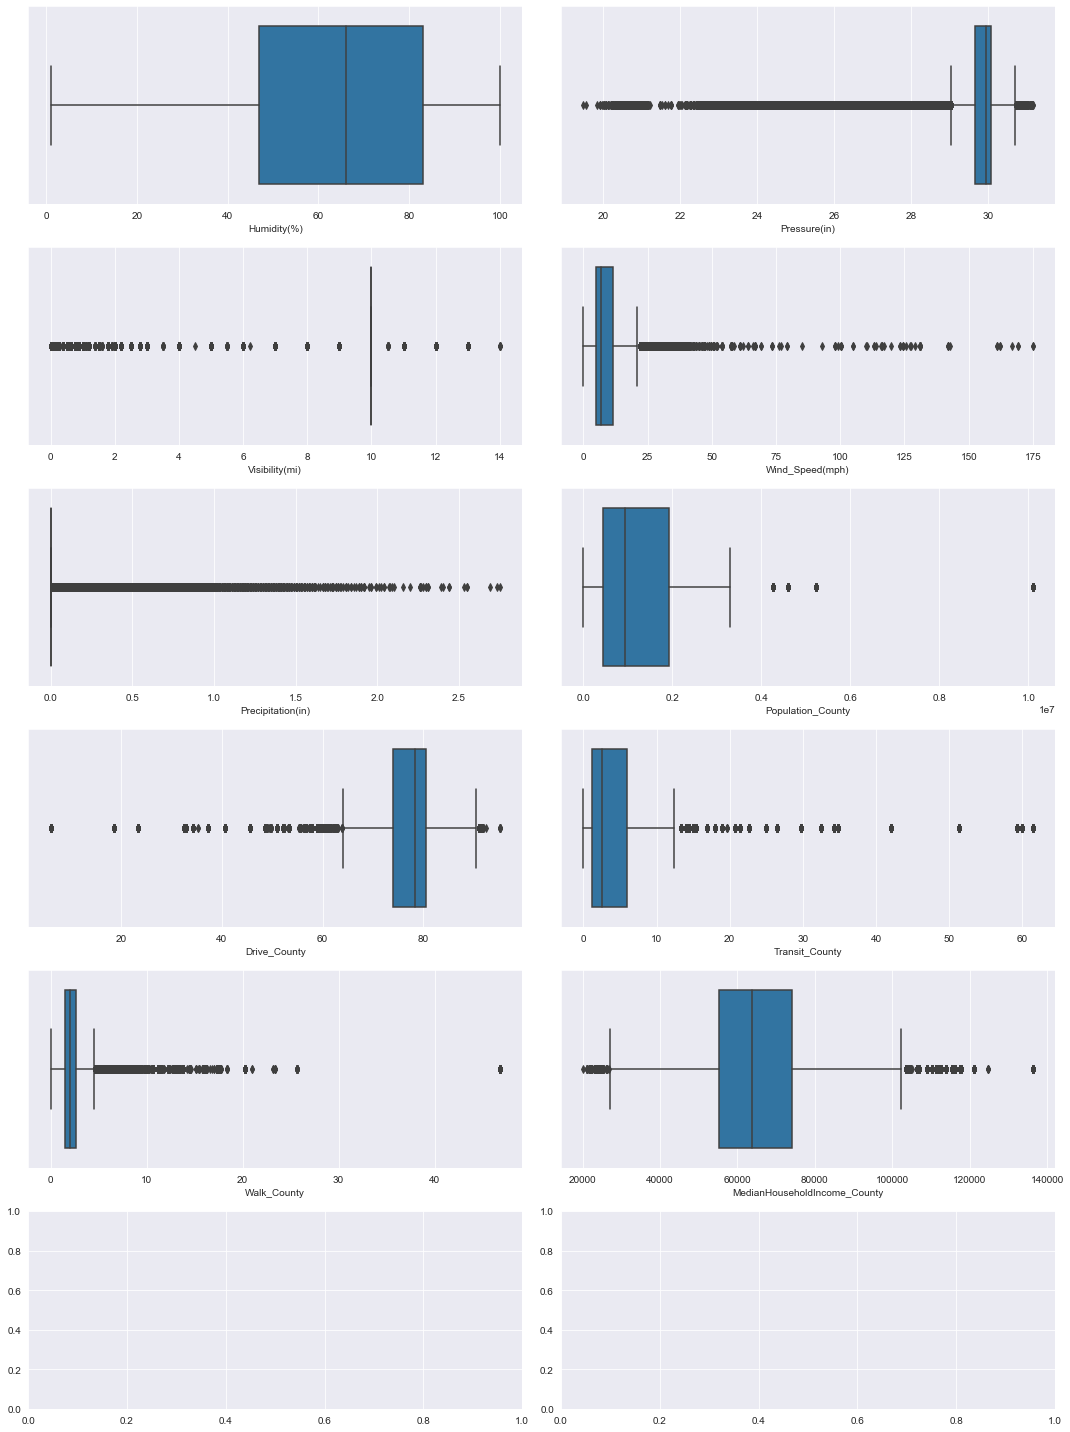

In [38]:
#Boxplot after outlier removal
cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
        'Wind_Speed(mph)', 'Precipitation(in)',
       'Population_County', 'Drive_County', 'Transit_County', 'Walk_County', 'MedianHouseholdIncome_County']

sns.set_style('darkgrid')
f, axes = plt.subplots(6,2, figsize=(15,20))
y = 0;
for name in cols[1:]:
    i, j = divmod(y, 2)
    sns.boxplot(x=data[name], ax=axes[i, j])
    y = y+1

plt.tight_layout()
plt.show()

In [ ]:
data['Grouped_Severity'] = np.where(data['Severity']<=2, 0, 1)
labels = data['Grouped_Severity']
#dropping percipitation and visibility due to all values removed as outliers
X = data.drop(['Severity',"Grouped_Severity",'Precipitation(in)','Visibility(mi)'], axis=1)

accuracies = Neural_Network(data,labels,best_neuron_size,20,5)
for i in range(1,4):
    print("Fold ",i," Accuracy: ",accuracies[i])
print("Average Accuracy: ",np.mean(accuracies))